In [1]:

import numpy as np
import pandas as pd
import os
from typing import List 
import easyocr
import re
import requests
import shutil
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

## Download images

### Download one single image

In [ ]:
def download_image(url, save_folder):
    
    response = requests.get(url, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        filename = url.split('/')[-1]
        save_path = os.path.join(os.getcwd(), save_folder, filename)
        with open(save_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        print(f"Image successfully downloaded: {save_path}")
    else:
        print(f"Failed to retrieve image. HTTP Status code: {response.status_code}")

# URL of the image to be downloaded
image_url = 'https://www.stats.gov.cn/sj/ndsj/2023/html/E19-03.jpg'

# Folder where the image will be saved
save_folder = '..\Data\Raw\Real_estate'

# Download the image
download_image(image_url, save_folder)

### Download multiple images

In [5]:
def download_image(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    else:
        print(f"Failed to download {url}")

# Base URL parts
base_url = "https://www.stats.gov.cn/sj/ndsj/2023/html/E19-"
file_extension = ".jpg"

# Directory to save images
save_dir = "..\Data\Raw\Real_estate"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Range of numbers to download images
start_num = 4
end_num = 17

# Loop through the range and download each image
for i in range(start_num, end_num + 1):
    # Construct the URL
    image_num = f"{i:02}"  # Format number to be two digits
    url = f"{base_url}{image_num}{file_extension}"
    
    # Construct the save path
    save_path = os.path.join(save_dir, f"E19-{image_num}{file_extension}")
    
    # Download and save the image
    download_image(url, save_path)

Downloaded ..\Data\Raw\Real_estate\E19-04.jpg
Downloaded ..\Data\Raw\Real_estate\E19-05.jpg
Downloaded ..\Data\Raw\Real_estate\E19-06.jpg
Downloaded ..\Data\Raw\Real_estate\E19-07.jpg
Downloaded ..\Data\Raw\Real_estate\E19-08.jpg
Downloaded ..\Data\Raw\Real_estate\E19-09.jpg
Downloaded ..\Data\Raw\Real_estate\E19-10.jpg
Downloaded ..\Data\Raw\Real_estate\E19-11.jpg
Downloaded ..\Data\Raw\Real_estate\E19-12.jpg
Downloaded ..\Data\Raw\Real_estate\E19-13.jpg
Downloaded ..\Data\Raw\Real_estate\E19-14.jpg
Downloaded ..\Data\Raw\Real_estate\E19-15.jpg
Downloaded ..\Data\Raw\Real_estate\E19-16.jpg
Downloaded ..\Data\Raw\Real_estate\E19-17.jpg


## OCR

In [2]:
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
def ocr_scan(image_path: str) -> str:
    result = reader.readtext(str(image_path))
        
    recognized = " ".join(element[1] for element in result)
    return recognized

## Preprocessing and Visualization

In [4]:
# Function to remove a specific sentence from a paragraph
def remove_sentence(paragraph, sentence):
    # Escape special characters in the sentence for regex
    escaped_sentence = re.escape(sentence)
    
    # Use regex to remove the sentence and any extra whitespace that may be left
    modified_paragraph = re.sub(r'\s*{}\s*'.format(escaped_sentence), ' ', paragraph)
    
    # Clean up any extra spaces created by removal
    modified_paragraph = re.sub(r'\s{2,}', ' ', modified_paragraph).strip()
    
    return modified_paragraph

In [47]:
# Function to append numbers into lines 
def process_numbers(paragraph, chunk_num, check_num, dict):
    # Split the paragraph into individual numbers
    numbers = paragraph.split()
    
    dict_length = len(dict)
    keys_ls = [key for key in dict.keys()]
    
    # Initialize a list to store the result lines
    result_lines = []
    
    # Process the numbers in chunks of chunk_num
    for i in range(0, len(numbers), chunk_num):
        chunk = numbers[i:i + chunk_num]
        
        chunk_ls = []
        
        # If there are at least check_num numbers in the chunk, take the needed ones
        if len(chunk) >= check_num:
            for j in range(check_num):
                chunk_ls.append(chunk[dict[keys_ls[j]]])
                
            selected_string = ' '.join(chunk_ls)
            result_lines.append(selected_string)
    
    # Join the result lines with newline characters
    return "\n".join(result_lines)

### Image E19-01

In [6]:
img_path = "..\..\Data\Raw\Real_estate\E19-01.jpg" 
real_estate_indicator = ocr_scan(img_path)

In [7]:
real_estate_indicator

'19-1 Main Indicators of Enterprises for Real Estate Development Item 2019 2020 2021 2022 Number ofEnterprises (unit) 99544 103262 105434 102852 Domestic Invested 95691 99150 101374 99054 State Otned Enterprises 671 1133 1209 1387 Collective-owned Enterprises 230 227 208 185 Enterprises with Investment from Hong Kong; Macao and Taiwan 2664 2759 2703 2550 Foreign Invested 1189 1353 1357 1248 Arerage Number Employed ersons (10 000 persons) 293.74 290.13 280.16 244.67 Domestic Invested 278.41 274.65 265.76 232.80 State Otned Enterprises 2.51 3.65 3.54 3.74 Collective-owned Enterprises 0.50 0.41 Enterprises with Investment from Hong Kong; Macao and Taiwan 10.37 10.19 9.24 Foreign Invested 4.95 5.29 5.15 Area of Land Purchased in the Year (10 000 sq.m) 25822.3 25536.3 21589_ 10041.7 ntesmment Completed in the Year (100 million yuan) 127746.8 136438.2 142247.7 128074.6 Residential Buildings 93572.4 100488.2 106855_ 96735 Actual Funds in Place in the Year (100 million yuan) 178608.6 193114.9 

#### Save into txt file

##### Remove the title of the table

In [8]:
# The paragraph needed to remove sentences
paragraph_01 = real_estate_indicator

# Sentence to be removed
sentence_to_remove = "19-1 Main Indicators of Enterprises for Real Estate Development Item 2019 2020 2021 2022"

# Remove the specified sentence from the paragraph
updated_paragraph_01 = remove_sentence(paragraph_01, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_01)

Number ofEnterprises (unit) 99544 103262 105434 102852 Domestic Invested 95691 99150 101374 99054 State Otned Enterprises 671 1133 1209 1387 Collective-owned Enterprises 230 227 208 185 Enterprises with Investment from Hong Kong; Macao and Taiwan 2664 2759 2703 2550 Foreign Invested 1189 1353 1357 1248 Arerage Number Employed ersons (10 000 persons) 293.74 290.13 280.16 244.67 Domestic Invested 278.41 274.65 265.76 232.80 State Otned Enterprises 2.51 3.65 3.54 3.74 Collective-owned Enterprises 0.50 0.41 Enterprises with Investment from Hong Kong; Macao and Taiwan 10.37 10.19 9.24 Foreign Invested 4.95 5.29 5.15 Area of Land Purchased in the Year (10 000 sq.m) 25822.3 25536.3 21589_ 10041.7 ntesmment Completed in the Year (100 million yuan) 127746.8 136438.2 142247.7 128074.6 Residential Buildings 93572.4 100488.2 106855_ 96735 Actual Funds in Place in the Year (100 million yuan) 178608.6 193114.9 201132.2 148357.3 Domestic Loans 25228 26675.9 23295 17359 Foreign Investment 175.7 192.0 

##### Save into txt file

In [ ]:
# Intialize a spellchecker used for saving into txt files
spell_checker = SpellChecker()

# Define a function used to seperate the paragraph into lines 
def separate_paragraph(paragraph):
    # Define the regex pattern to find groups of words followed by 2 to 4 consecutive numbers
    pattern = re.compile(r'([a-zA-Z\s\-,\(\)._]+)((?:\s\d+(?:\.\d+)?_?){2,4})')
    
    # Find all matches in the paragraph
    matches = pattern.findall(paragraph)
    
    lines = []
    for match in matches:
        # Combine the words part and the numbers part into a single line
        words = match[0].strip()
        
        # Spellchecker use
        for word in words:
            if spell_checker.correction(word) != word:
                word = spell_checker.candidates(word)
        
        numbers = match[1].strip()
        line = f"{words} {numbers}"
        lines.append(line)
    
    return lines

# Input paragraph
paragraph = updated_paragraph_01

lines = separate_paragraph(paragraph)

output_e19_01 = "..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_01.txt"

with open(output_e19_01, 'w') as file:
    for line in lines:
        file.write(line + '\n')

### Image E19-02

In [9]:
img_path = "..\..\Data\Raw\Real_estate\E19-02.jpg"
real_estate_enterprises = ocr_scan(img_path)

In [10]:
real_estate_enterprises

'19-2 Number of Enterprises for Real Estate Development (unit) Number of Domestic Enterprises Foreign Year Enterprises Invested State-owned Collective- with Investnent Invested Region Enterprises Enterprises owned from Hong Kong; Enterprises Enterprises Macao and Taiwan 998 24378 19960 7958 4538 3214 1204 2000 27303 23277 6641 3492 2899 1127 2005 56290 50957 4145 1796 3443 1890 2006 58710 53268 3797 1586 3519 1923 2007 62518 56965 3617 1430 3524 2029 2008 87562 81282 3941 1520 3916 2364 2009 80407 74674 3835 1361 3633 2100 2010 85218 79489 3685 1220 3677 2052 2011 88419 83011 3427 1023 3565 1843 2012 89859 84695 3354 904 3451 1713 2013 91444 86379 1739 570 3391 1674 201- 94197 89218 1476 457 3414 1565 2015 93426 88773 1329 409 3235 1418 2016 94948 90408 1093 364 3232 1308 2017 95897 91608 943 319 3066 1223 2018 97937 94063 767 280 2719 1155 2019 99544 95691 671 230 2664 1189 2020 103262 99150 1133 227 2759 1353 2021 105434 101374 1209 208 2703 1357 2022 102852 99054 1387 185 2550 1248 

In [11]:
paragraph_02 = real_estate_enterprises

# Sentence to be removed
sentence_to_remove = "19-2 Number of Enterprises for Real Estate Development (unit) Number of Domestic Enterprises Foreign Year Enterprises Invested State-owned Collective- with Investnent Invested Region Enterprises Enterprises owned from Hong Kong; Enterprises Enterprises Macao and Taiwan"

# Remove the specified sentence from the paragraph
updated_paragraph_02 = remove_sentence(paragraph_02, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_02)

998 24378 19960 7958 4538 3214 1204 2000 27303 23277 6641 3492 2899 1127 2005 56290 50957 4145 1796 3443 1890 2006 58710 53268 3797 1586 3519 1923 2007 62518 56965 3617 1430 3524 2029 2008 87562 81282 3941 1520 3916 2364 2009 80407 74674 3835 1361 3633 2100 2010 85218 79489 3685 1220 3677 2052 2011 88419 83011 3427 1023 3565 1843 2012 89859 84695 3354 904 3451 1713 2013 91444 86379 1739 570 3391 1674 201- 94197 89218 1476 457 3414 1565 2015 93426 88773 1329 409 3235 1418 2016 94948 90408 1093 364 3232 1308 2017 95897 91608 943 319 3066 1223 2018 97937 94063 767 280 2719 1155 2019 99544 95691 671 230 2664 1189 2020 103262 99150 1133 227 2759 1353 2021 105434 101374 1209 208 2703 1357 2022 102852 99054 1387 185 2550 1248 Beijing 1182 1109 Tianjin 1127 1064 Hebei 4036 4002 Shanxi 2768 2756 Inner Mongolia 1711 1710 Liaoning 2757 2558 149 Jilin 1444 1432 Heilongjiang 1359 1344 Shanghai 2660 2297 128 267 Jiangsu 7146 5574 188 426 146 Zhejiang 6599 5341 130 128 Anhui 3962 902 Fujian 3426 3162

In [ ]:
paragraph = updated_paragraph_02

dict_02 = {
    'id1': 0,
    'id2': 1
}
result = process_numbers(paragraph, 7, 2, dict_02)

# Save into txt file
with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_02.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_02.txt")

In [49]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_02.txt'

# Initialize empty lists to store the data
years = []
num_enterprises_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 2:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                num_enterprises = int(parts[1])
                years.append(year)
                num_enterprises_list.append(num_enterprises)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'Number of Enterprises': num_enterprises_list}
df_02 = pd.DataFrame(data)
    
df_02

,Year,Number of Enterprises
0,1998,24378
1,2000,27303
2,2005,56290
3,2006,58710
4,2007,62518
5,2008,87562
6,2009,80407
7,2010,85218
8,2011,88419
9,2012,89859


#### Number of Enterprises Visualization

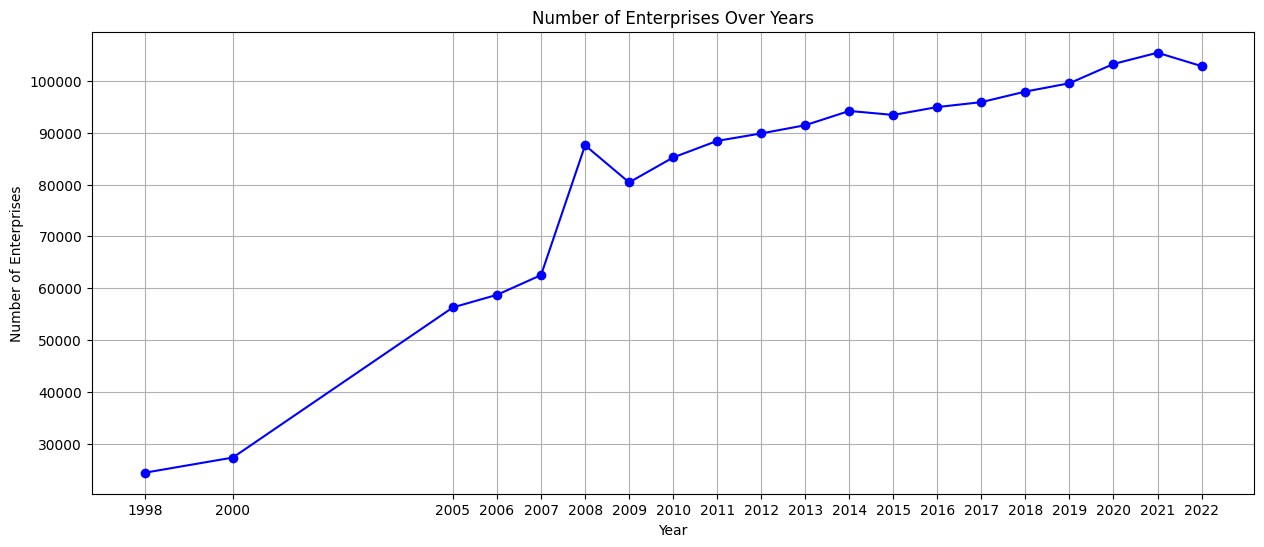

In [50]:
# Plot the line chart for Number of Enterprises over Years    
plt.figure(figsize=(15, 6))
plt.plot(df_02['Year'], df_02['Number of Enterprises'], marker='o', linestyle='-', color='b')

# Set the ticks on the x-axis to be the specific years in the DataFrame
plt.xticks(df_02['Year'])

plt.xlabel('Year')
plt.ylabel('Number of Enterprises')
plt.title('Number of Enterprises Over Years')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\Enterprises.png")

plt.show()

### Image E19-03

In [51]:
img_path = "..\..\Data\Raw\Real_estate\E19-03.jpg" 
number_of_employed = ocr_scan(img_path)

In [52]:
number_of_employed

'19-3 Number of Employed Persons in Enterprises for Real Estate Development (person) Average Year Number of Domestic Enterprises Foreign Employed Invested State-owned Collective - with Investment Invested Region Persons Enterprises Enterprises owned from Hong Kong: Enterprises Enterprises Macao and Taiwan 1998 825888 708738 332834 134939 83784 33366 2000 971942 862245 292252 116416 79066 30631 2005 1516150 1366743 140106 40978 90674 58733 2006 1600930 1442158 132259 38367 97688 61084 2007 1719666 1541336 121137 34498 100398 77932 2008 2100362 1906029 127511 29602 109246 85087 2009 1949295 1763867 123866 29049 109965 75463 2010 2091147 1908969 155156 25428 105846 76332 2011 2256964 2075474 135420 21237 112990 68500 2012 2386772 2199815 123593 20398 116849 70108 2013 2591814 2397762 66072 12976 121807 72245 201- 2760070 2561817 61512 11414 129287 68966 2015 2738454 2551484 57273 10771 124494 62476 2016 2752298 2576545 47085 9916 118495 57258 2017 2830960 2663954 37904 9092 113221 53785 2

In [53]:
paragraph_03 = number_of_employed

# Sentence to be removed
sentence_to_remove = "19-3 Number of Employed Persons in Enterprises for Real Estate Development (person) Average Year Number of Domestic Enterprises Foreign Employed Invested State-owned Collective - with Investment Invested Region Persons Enterprises Enterprises owned from Hong Kong: Enterprises Enterprises Macao and Taiwan"

# Remove the specified sentence from the paragraph
updated_paragraph_03 = remove_sentence(paragraph_03, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_03)

1998 825888 708738 332834 134939 83784 33366 2000 971942 862245 292252 116416 79066 30631 2005 1516150 1366743 140106 40978 90674 58733 2006 1600930 1442158 132259 38367 97688 61084 2007 1719666 1541336 121137 34498 100398 77932 2008 2100362 1906029 127511 29602 109246 85087 2009 1949295 1763867 123866 29049 109965 75463 2010 2091147 1908969 155156 25428 105846 76332 2011 2256964 2075474 135420 21237 112990 68500 2012 2386772 2199815 123593 20398 116849 70108 2013 2591814 2397762 66072 12976 121807 72245 201- 2760070 2561817 61512 11414 129287 68966 2015 2738454 2551484 57273 10771 124494 62476 2016 2752298 2576545 47085 9916 118495 57258 2017 2830960 2663954 37904 9092 113221 53785 2018 2889165 2735301 31383 6585 104378 49486 2019 2937379 2784130 25129 5018 103746 49503 2020 2901253 2746467 36517 4953 101924 52862 2021 2801571 2657629 35442 4085 92414 51528 2022 2446671 2328044 37407 4521 78151 40476 38717 34789 2238 1690 Tianjin 24793 21779 1237 1997 1017 Hebei 99016 97836 370 543 Sh

In [54]:
paragraph = updated_paragraph_03

dict_03 = {
    'id1': 0,
    'id2': 1
}

result = process_numbers(paragraph, 7, 2, dict_03)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_03_test.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_03.txt")

In [55]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_03.txt'

# Initialize empty lists to store the data
years = []
num_employed_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 2:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                num_enterprises = int(parts[1])
                years.append(year)
                num_employed_list.append(num_enterprises)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'Average Number of employed people': num_employed_list}
df_03 = pd.DataFrame(data)

df_03

,Year,Average Number of employed people
0,1998,825888
1,2000,971942
2,2005,1516150
3,2006,1600930
4,2007,1719666
5,2008,2100362
6,2009,1949295
7,2010,2091147
8,2011,2256964
9,2012,2386772


#### Number of employed people in Enterprises for Real estate development

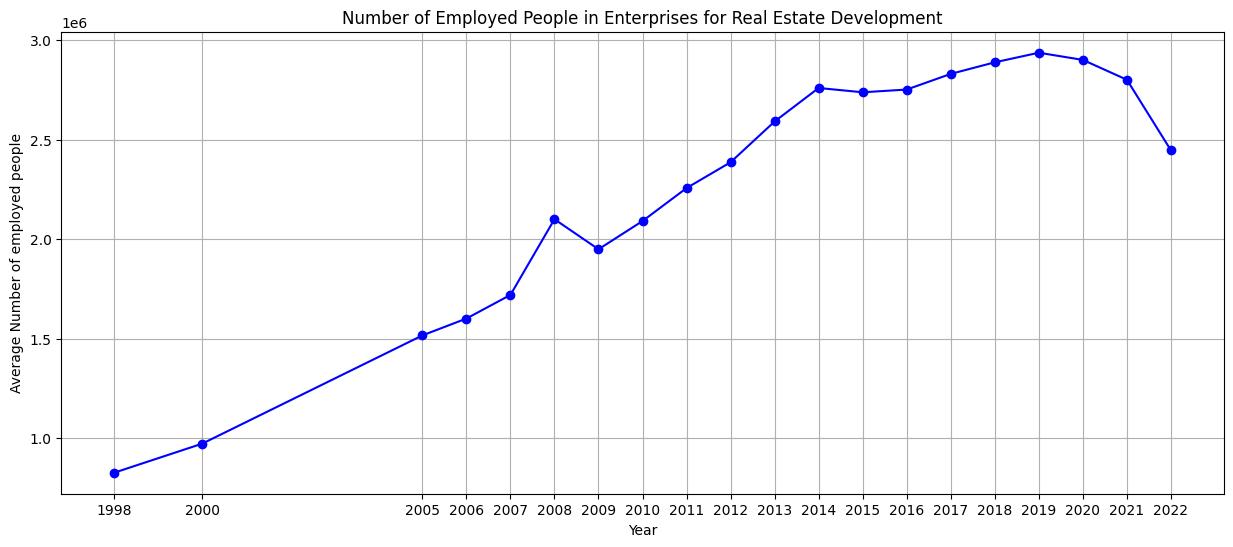

In [56]:
plt.figure(figsize=(15, 6))
plt.plot(df_03['Year'], df_03['Average Number of employed people'], marker='o', linestyle='-', color='b')

# Set the ticks on the x-axis to be the specific years in the DataFrame
plt.xticks(df_03['Year'])

plt.xlabel('Year')
plt.ylabel('Average Number of employed people')
plt.title('Number of Employed People in Enterprises for Real Estate Development')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\Employed.png")
    
plt.show()


#### Number of employed people in foreign invested Enterprises for Real estate development

In [57]:
paragraph = updated_paragraph_03

dict_03_f = {
    'id1': 0,
    'id2': 6
}

result = process_numbers(paragraph, 7, 2, dict_03_f)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_03_foreign.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_03_foreign.txt")

In [60]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_03_foreign.txt'

years = []
num_employed_f_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 2:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                num_enterprises = int(parts[1])
                years.append(year)
                num_employed_f_list.append(num_enterprises)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'Average Number of employed people in Foreign invested Enterprises': num_employed_f_list}
df_03_f = pd.DataFrame(data)

df_03_f

,Year,Average Number of employed people in Foreign invested Enterprises
0,1998,33366
1,2000,30631
2,2005,58733
3,2006,61084
4,2007,77932
5,2008,85087
6,2009,75463
7,2010,76332
8,2011,68500
9,2012,70108


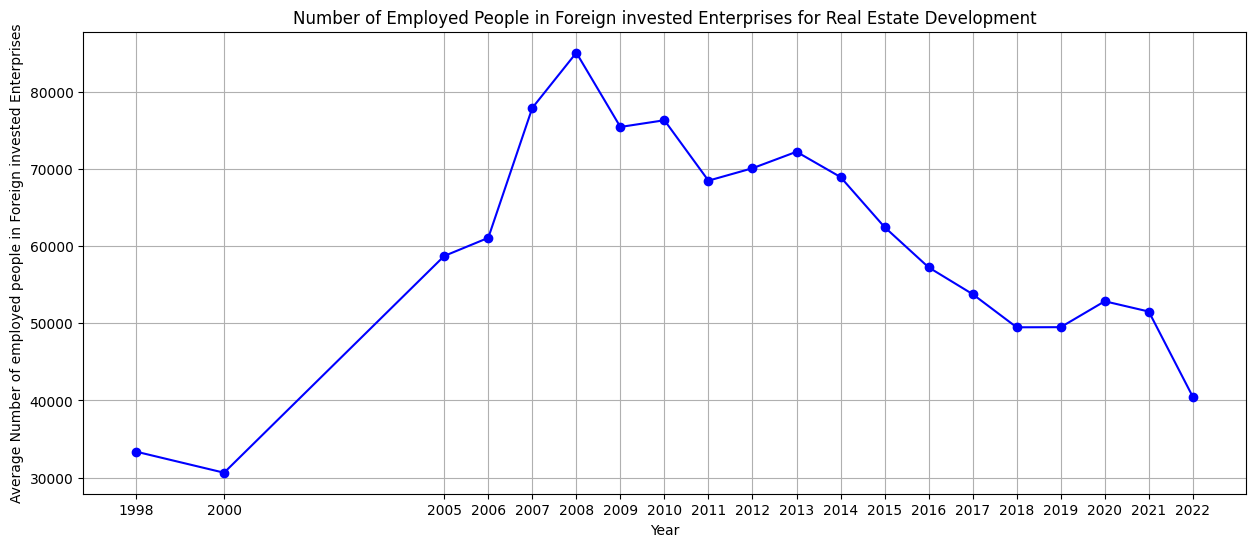

In [62]:

plt.figure(figsize=(15, 6))
plt.plot(df_03_f['Year'], df_03_f['Average Number of employed people in Foreign invested Enterprises'], marker='o', linestyle='-', color='b')

# Set the ticks on the x-axis to be the specific years in the DataFrame
plt.xticks(df_03_f['Year'])

plt.xlabel('Year')
plt.ylabel('Average Number of employed people in Foreign invested Enterprises')
plt.title('Number of Employed People in Foreign invested Enterprises for Real Estate Development')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\Employed_foreign.png")

plt.show()

### Image E19-04

In [25]:
img_path = "..\..\Data\Raw\Real_estate\E19-04.jpg"
land_development = ocr_scan(img_path)

In [26]:
land_development

'19-4 Land Development and Purchase of Enterprises for Real Estate Development Area ofLand Area ofLand Transaction Value Year Pending for Purchased ofLand Development in the Year in the Year Region (10 O00 (10 000 sg,m) (100 million yuan) 1998 13530.70 10109.32 2000 14754.77 16905.24 2005 27522.00 38253.73 3269.32 2006 37523.65 36573.57 3318.04 2007 41483.97 40245.85 4573.18 2008 48161.07 39353.43 4831.68 2009 32816.54 31909.45 5150.14 2010 31457.95 39953.10 8206.71 2011 40220.76 44327.44 8894.03 2012 40195.99 35666.80 7409.64 2013 42280.47 38814.38 9918.29 2014 42136.28 33383.03 10019.88 2015 36638.48 22810.79 7621.61 2016 35121.01 22025.25 9129.31 2017 35747.29 25508.29 13643.39 2018 45804.02 29320.65 16154.08 2019 48976.94 25822.29 14709.28 2020 43514.51 25536.28 17268.83 2021 47490.09 21589.86 17756.28 2022 49827.72 10041.73 9163.79 615.25 188.82 853.51 Tianjin 644.35 182.88 125.32 Hebei 2256.29 224.46 85.43 Shanxi 876.46 228.10 85.11 Inner Mongolia 784.72 97.64 12.34 Liaoning 1629

In [28]:
paragraph_04 = land_development

# Sentence to be removed
sentence_to_remove = "19-4 Land Development and Purchase of Enterprises for Real Estate Development Area ofLand Area ofLand Transaction Value Year Pending for Purchased ofLand Development in the Year in the Year Region (10 O00 (10 000 sg,m) (100 million yuan)"

# Remove the specified sentence from the paragraph
updated_paragraph_04 = remove_sentence(paragraph_04, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_04)

1998 13530.70 10109.32 2000 14754.77 16905.24 2005 27522.00 38253.73 3269.32 2006 37523.65 36573.57 3318.04 2007 41483.97 40245.85 4573.18 2008 48161.07 39353.43 4831.68 2009 32816.54 31909.45 5150.14 2010 31457.95 39953.10 8206.71 2011 40220.76 44327.44 8894.03 2012 40195.99 35666.80 7409.64 2013 42280.47 38814.38 9918.29 2014 42136.28 33383.03 10019.88 2015 36638.48 22810.79 7621.61 2016 35121.01 22025.25 9129.31 2017 35747.29 25508.29 13643.39 2018 45804.02 29320.65 16154.08 2019 48976.94 25822.29 14709.28 2020 43514.51 25536.28 17268.83 2021 47490.09 21589.86 17756.28 2022 49827.72 10041.73 9163.79 615.25 188.82 853.51 Tianjin 644.35 182.88 125.32 Hebei 2256.29 224.46 85.43 Shanxi 876.46 228.10 85.11 Inner Mongolia 784.72 97.64 12.34 Liaoning 1629.80 320.09 91.57 Jilin 704.88 245.36 54.31 Heilongjiang 245.29 107.74 15.50 Shanghai 247.63 148.02 840.24 Jiangsu 4038.82 691.76 773.11 Zhejiang 1083.54 972.32 1714.21 Anhui 2951.08 1420.31 778.43 Fujian 853.03 299.08 473.92 Jiangxi 1229.0

In [31]:
# A specific number processing function for this image due to its structure
def process_numbers_04(paragraph):
    # Split the paragraph into individual numbers
    numbers = paragraph.split()
    
    # Initialize a list to store the result lines
    result_lines = []
    
    for i in range(0, 6, 3):
        # Extract the current chunk of 3 numbers
        chunk = numbers[i:i + 3]
        
        # If there are at least three numbers in the chunk, take the first three
        if len(chunk) >= 3:
            result_lines.append(f"{chunk[0]} {chunk[1]} {chunk[2]}")
    
    for i in range(6, len(numbers), 4):
        # Extract the current chunk of 4 numbers
        chunk = numbers[i:i + 4]
        
        # If there are at least four numbers in the chunk, take the first three
        if len(chunk) >= 4:
            result_lines.append(f"{chunk[0]} {chunk[1]} {chunk[2]}")
    
    return "\n".join(result_lines)

paragraph = updated_paragraph_04

result = process_numbers_04(paragraph)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_04.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_04.txt")

Result has been saved to E19_04.txt


In [63]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_04.txt'

years = []
pending_list = []
purchased_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 3:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                pending = float(parts[1])
                purchased = float(parts[2])
                years.append(year)
                pending_list.append(pending)
                purchased_list.append(purchased)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'Area of Land Pending for Development': pending_list, 'Area of Land Purchased in the year': purchased_list}
df_04 = pd.DataFrame(data)

df_04

,Year,Area of Land Pending for Development,Area of Land Purchased in the year
0,1998,13530.70,10109.32
1,2000,14754.77,16905.24
2,2005,27522.00,38253.73
3,2006,37523.65,36573.57
4,2007,41483.97,40245.85
5,2008,48161.07,39353.43
6,2009,32816.54,31909.45
7,2010,31457.95,39953.10
8,2011,40220.76,44327.44
9,2012,40195.99,35666.80


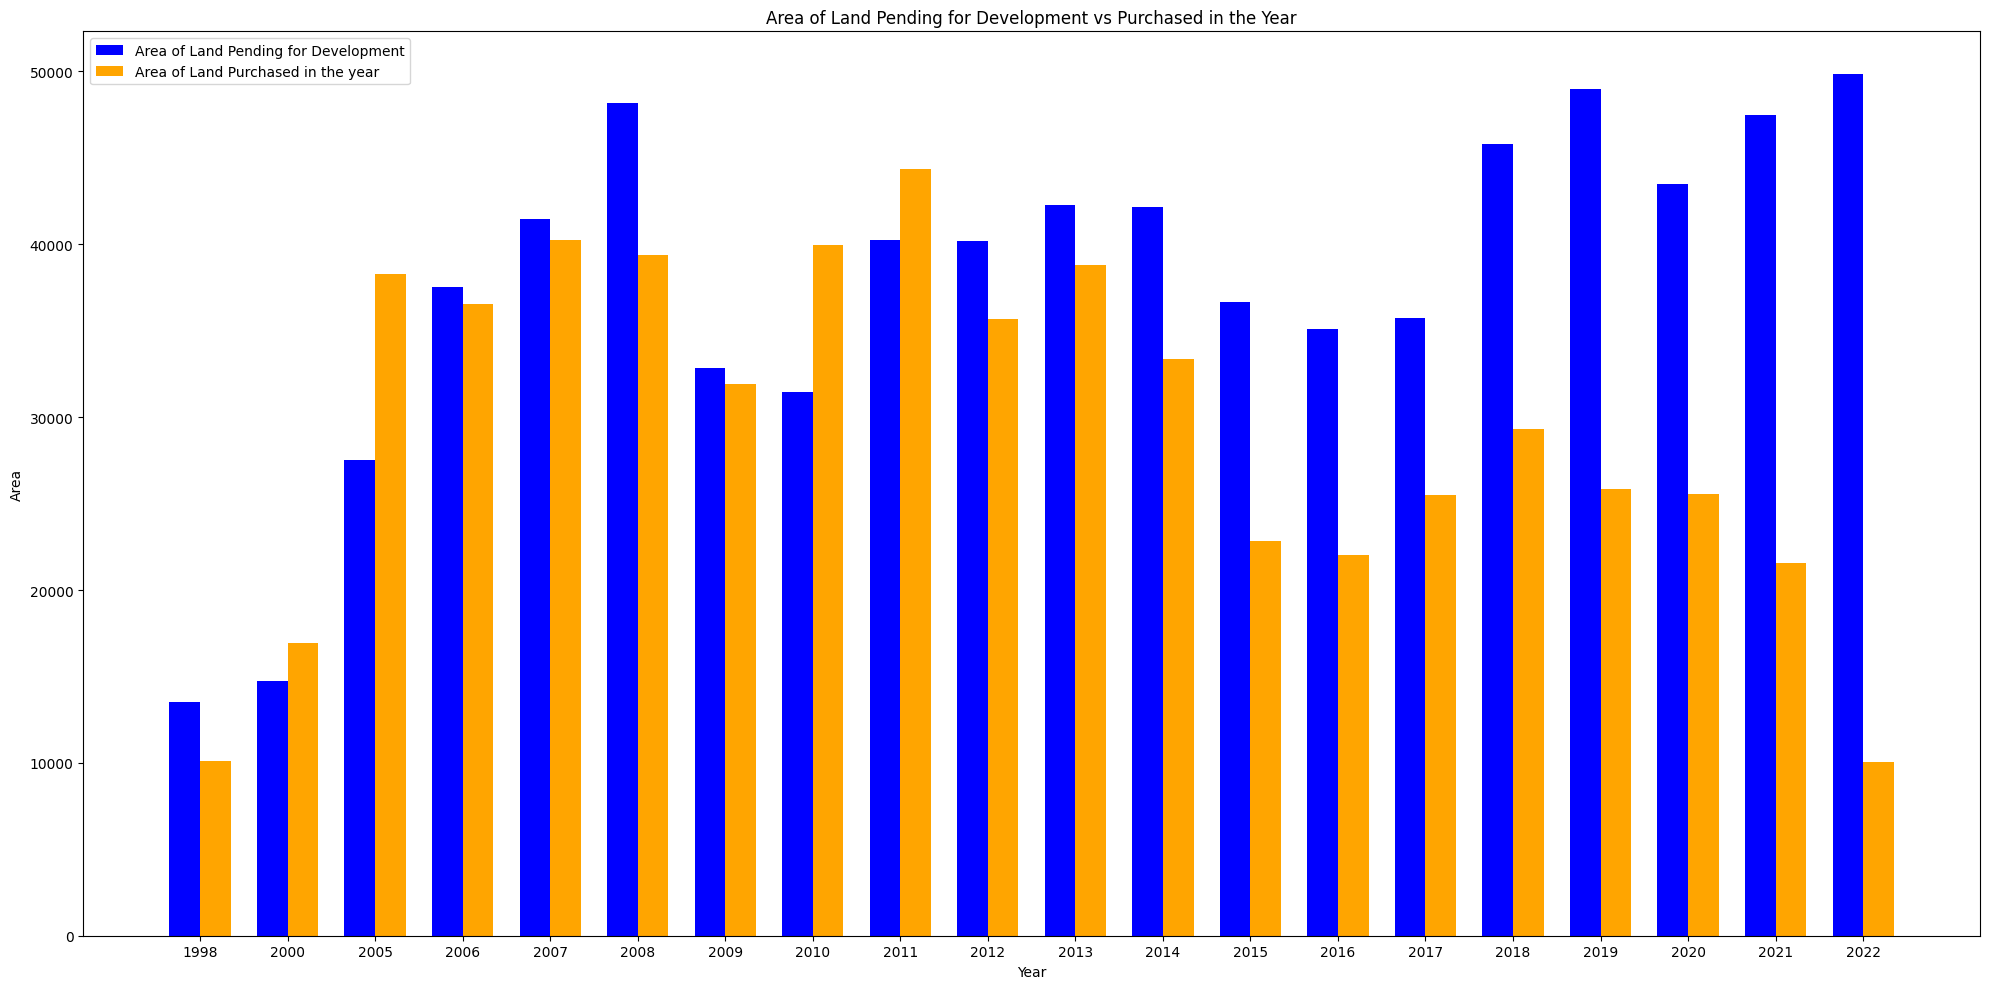

In [64]:
bar_width = 0.35
bar_positions = np.arange(len(df_04['Year']))

# Create the plot
plt.figure(figsize=(20, 10))

# Plot the bars for 'Area of Land Pending for Development'
plt.bar(bar_positions - bar_width/2, df_04['Area of Land Pending for Development'], width=bar_width, color='blue', label='Area of Land Pending for Development')

# Plot the bars for 'Area of Land Purchased in the year'
plt.bar(bar_positions + bar_width/2, df_04['Area of Land Purchased in the year'], width=bar_width, color='orange', label='Area of Land Purchased in the year')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Area')
plt.title('Area of Land Pending for Development vs Purchased in the Year')
plt.xticks(bar_positions, df_04['Year'])
plt.legend()

# Show the plot
plt.tight_layout()

# # Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\Pending_Purchased.png")

plt.show()

### Image E19-07

In [38]:
img_path = "..\..\Data\Raw\Real_estate\E19-07.jpg"
actual_funds = ocr_scan(img_path)

In [39]:
actual_funds

'19-7 Actual Funds in Place of Enterprises for Real Estate Development (100 million yuan) Actual Funds Domestic Foreign Self-raised Deposit and Individual Others earRegion in Place Loans Investment Funds Advance Mortgage in the Year Payment Loans 1998 4414.94 1053.17 361.76 1166.98 2000 5997.63 1385.08 168.70 1614.21 2005 21397.84 3918.08 257.81 7000.39 6954.23 1341.18 1926.15 2006 27135.55 5356.98 400.15 8597.09 8192.65 2588.38 2000.30 2007 37477.96 7015.64 641.04 11772.53 10663.20 5080.43 2305.12 2008 39619.36 7605.69 728.22 1531210 9756.68 3886.04 2330.63 2009 57799.04 11364.51 479.39 17949.12 16217.49 8561.65 3226.88 2010 72944.04 12563.70 790.68 26637.21 19275.15 9523.77 4153.53 2011 85688.73 13056.80 785.15 35004.57 22470.32 8678.37 5693.53 2012 96536.81 14778.39 402.09 39081.96 26558.02 10523.78 5192.57 2013 122122.47 19672.66 534.17 47424.95 34498.97 14033.26 5958.47 2014 121991.48 21242.61 639.26 50419.80 30237.51 13665.45 5786.85 2015 125203.06 20214.38 296.53 49037.56 32520.

In [41]:
paragraph_07 = actual_funds

# Sentence to be removed
sentence_to_remove = "19-7 Actual Funds in Place of Enterprises for Real Estate Development (100 million yuan) Actual Funds Domestic Foreign Self-raised Deposit and Individual Others earRegion in Place Loans Investment Funds Advance Mortgage in the Year Payment Loans"

# Remove the specified sentence from the paragraph
updated_paragraph_07 = remove_sentence(paragraph_07, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_07)

1998 4414.94 1053.17 361.76 1166.98 2000 5997.63 1385.08 168.70 1614.21 2005 21397.84 3918.08 257.81 7000.39 6954.23 1341.18 1926.15 2006 27135.55 5356.98 400.15 8597.09 8192.65 2588.38 2000.30 2007 37477.96 7015.64 641.04 11772.53 10663.20 5080.43 2305.12 2008 39619.36 7605.69 728.22 1531210 9756.68 3886.04 2330.63 2009 57799.04 11364.51 479.39 17949.12 16217.49 8561.65 3226.88 2010 72944.04 12563.70 790.68 26637.21 19275.15 9523.77 4153.53 2011 85688.73 13056.80 785.15 35004.57 22470.32 8678.37 5693.53 2012 96536.81 14778.39 402.09 39081.96 26558.02 10523.78 5192.57 2013 122122.47 19672.66 534.17 47424.95 34498.97 14033.26 5958.47 2014 121991.48 21242.61 639.26 50419.80 30237.51 13665.45 5786.85 2015 125203.06 20214.38 296.53 49037.56 32520.34 16661.65 6472.61 2016 144214.05 21512.40 140.44 49132.85 41952.14 24402.94 7073.29 2017 156052.62 25241.76 168.19 50872.22 48693.57 23906.31 7170.58 2018 166407.11 24132.14 114.02 55754.79 55748.16 23643.06 7014.94 2019 178608.59 25228.77 175.7

In [42]:
paragraph = updated_paragraph_07

dict_07 = {
    'id1': 0,
    'id2': 1,
    'id3': 4,
    'id4': 5,
    'id5': 6
}

result = process_numbers(paragraph, 8, 8, dict_07)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_07.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_07.txt")

Result has been saved to E19_07.txt


In [65]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_07.txt'

years = []
actual_list = []
self_raised_list = []
deposit_list = []
mortgage_list = []
other_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 5:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                actual = float(parts[1])
                self_raised = float(parts[2])
                deposit = float(parts[3])
                mortgage = float(parts[4])
                other = actual - (self_raised + deposit + mortgage)
                
                years.append(year)
                actual_list.append(actual)
                self_raised_list.append(self_raised)
                deposit_list.append(deposit)
                mortgage_list.append(mortgage)
                other_list.append(other)
                
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

data = {'Year': years,
        'Self-raised Funds': self_raised_list,
        'Deposit and Advance Payment': deposit_list,
        'Individual Mortgage': mortgage_list,
        'Other': other_list}

df_07 = pd.DataFrame(data)

df_07

,Year,Self-raised Funds,Deposit and Advance Payment,Individual Mortgage,Other
0,2005,7000.39,6954.23,1341.18,6102.04
1,2006,8597.09,8192.65,2588.38,7757.43
2,2007,11772.53,10663.20,5080.43,9961.80
3,2008,15312.10,9756.68,3886.04,10664.54
4,2009,17949.12,16217.49,8561.65,15070.78
5,2010,26637.21,19275.15,9523.77,17507.91
6,2011,35004.57,22470.32,8678.37,19535.47
7,2012,39081.96,26558.02,10523.78,20373.05
8,2013,47424.95,34498.97,14033.26,26165.29
9,2014,50419.80,30237.51,13665.45,27668.72


In [66]:
# Convert into percentage 
df_07_percentage = df_07

# Select only the numeric columns (excluding the 'Year' column)
numeric_columns = df_07_percentage.columns.difference(['Year'])

# Convert values to percentages
df_07_percentage[numeric_columns] = df_07_percentage[numeric_columns].div(df_07_percentage[numeric_columns].sum(axis=1), axis=0) * 100

df_07_percentage

,Year,Self-raised Funds,Deposit and Advance Payment,Individual Mortgage,Other
0,2005,32.715405,32.499682,6.267829,28.517084
1,2006,31.682019,30.191575,9.538705,28.587701
2,2007,31.411875,28.451922,13.555781,26.580422
3,2008,38.648025,24.626041,9.808437,26.917497
4,2009,31.054357,28.058407,14.812789,26.074447
5,2010,36.517322,26.424571,13.056269,24.001838
6,2011,40.850845,26.223192,10.127785,22.798179
7,2012,40.483998,27.510770,10.901313,21.103919
8,2013,38.833926,28.249486,11.491137,21.425451
9,2014,41.330591,24.786575,11.201971,22.680863


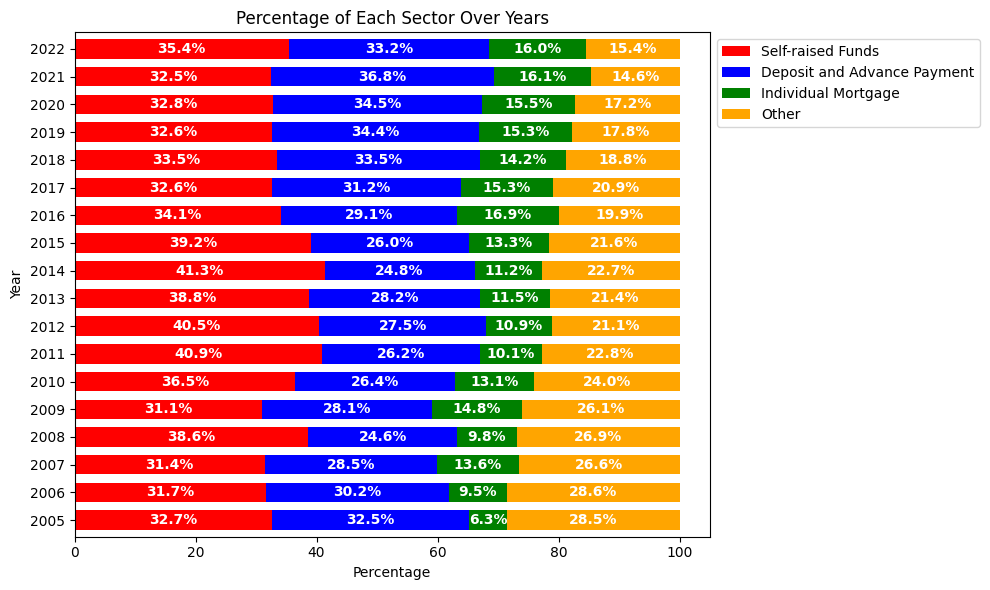

In [67]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red', 'blue', 'green', 'orange']

# Plot the horizontal stacked bar chart
bars = df_07_percentage.set_index('Year').plot(kind='barh', stacked=True, color=colors, width=0.7, ax=ax)

# Add labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Year')
ax.set_title('Percentage of Each Sector Over Years')

# Add percentages on the bars
for bar in bars.patches:
    width, height = bar.get_width(), bar.get_height()
    x, y = bar.get_xy() 
    ax.text(x + width / 2, y + height / 2, f'{width:.1f}%', ha='center', va='center',color='white',weight='bold')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig("..\..\Saved figures\Real estate\Funds.png")

plt.show()

### Image E19-08

In [65]:
img_path = "..\..\Data\Raw\Real_estate\E19-08.jpg"
floor_space = ocr_scan(img_path)

In [66]:
floor_space

'19-8 Floor Space and Cost of Buildings Constructed by Enterprises for Real Estate Development Floor Space of Floor Space Rate ofFloor Value of Cost of Year Buildings under of Buildings Space of Buildings Buildings Buildings Region Construction Completed Completed Completed Completed (10 O00 sqm) (10 O00 sqm) million yuan) (yuan sq m) 1998 50770.14 17566.60 34.6 2139.19 1218 2000 65896.92 25104.86 2859.35 1139 2005 166053.26 53417.04 32.2 7752.24 1451 2006 194786.42 55830.92 8729.35 1564 2007 236318.24 60606.68 25.6 10039.89 1657 2008 283266.20 66544.80 23.5 11947.57 1795 2009 320368.20 72677.40 14689.37 2021 2010 405356.40 78743.90 17542.73 2228 2011 506775.48 92619.94 18.3 21975.91 2373 2012 573417.52 99424.96 17.3 24836.62 2498 2013 665571.89 101434.99 15.2 26805.38 2643 201- 726482.34 107459.05 14.8 30261.99 2816 2015 735693.37 100039.10 13.6 30552.38 3054 2016 758974.80 106127.71 14.0 32252.13 3039 2017 781483.73 101486.41 13.0 31512.46 3105 2018 822299.56 94421.15 11.5 30309.07 3

In [67]:
paragraph_08 = floor_space

# Sentence to be removed
sentence_to_remove = "19-8 Floor Space and Cost of Buildings Constructed by Enterprises for Real Estate Development Floor Space of Floor Space Rate ofFloor Value of Cost of Year Buildings under of Buildings Space of Buildings Buildings Buildings Region Construction Completed Completed Completed Completed (10 O00 sqm) (10 O00 sqm) million yuan) (yuan sq m)"

# Remove the specified sentence from the paragraph
updated_paragraph_08 = remove_sentence(paragraph_08, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_08)

1998 50770.14 17566.60 34.6 2139.19 1218 2000 65896.92 25104.86 2859.35 1139 2005 166053.26 53417.04 32.2 7752.24 1451 2006 194786.42 55830.92 8729.35 1564 2007 236318.24 60606.68 25.6 10039.89 1657 2008 283266.20 66544.80 23.5 11947.57 1795 2009 320368.20 72677.40 14689.37 2021 2010 405356.40 78743.90 17542.73 2228 2011 506775.48 92619.94 18.3 21975.91 2373 2012 573417.52 99424.96 17.3 24836.62 2498 2013 665571.89 101434.99 15.2 26805.38 2643 201- 726482.34 107459.05 14.8 30261.99 2816 2015 735693.37 100039.10 13.6 30552.38 3054 2016 758974.80 106127.71 14.0 32252.13 3039 2017 781483.73 101486.41 13.0 31512.46 3105 2018 822299.56 94421.15 11.5 30309.07 3210 2019 893820.89 95941.53 34045.90 3549 2020 926759.19 91218.23 9.8 34493.83 3781 2021 975386.51 101411.94 10.4 39458.15 3891 2022 904091.85 85857.30 9.5 35093.54 4087 13333.15 1938.48 14.5 787.46 4062 Tianjin 11085.10 1503.65 13.6 593.05 3944 Hebei 33651.79 2522.65 7.5 877.77 3480 Shanxi 25350.51 2126.82 638.48 3002 Inner Mongolia 1

In [73]:
paragraph = updated_paragraph_08

dict_08 = {
    'id1': 0,
    'id2': 1,
    'id3': 2,
    'id4': 3,
    'id5': 4,
    'id6': 5
}

result = process_numbers(paragraph, 6, 6, dict_08)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_08.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_08.txt")

Result has been saved to E19_08.txt


In [68]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_08.txt'

years = []
construction_list = []
completed_list = []
rate_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 4:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                construction = float(parts[1])
                completed = float(parts[2])
                rate = float(parts[3])
                
                years.append(year)
                construction_list.append(construction)
                completed_list.append(completed)
                rate_list.append(rate)
            
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

data = {'Year': years,
        'Floor Space of Buildings under Construction': construction_list,
        'Floor Space of Buildings completed': completed_list,
        'Rate of Floor Space of Buildings completed': rate_list}

df_08 = pd.DataFrame(data)
    
df_08

,Year,Floor Space of Buildings under Construction,Floor Space of Buildings completed,Rate of Floor Space of Buildings completed
0,1998,50770.14,17566.60,34.6
1,2000,65896.92,25104.86,38.1
2,2005,166053.26,53417.04,32.2
3,2006,194786.42,55830.92,28.7
4,2007,236318.24,60606.68,25.6
5,2008,283266.20,66544.80,23.5
6,2009,320368.20,72677.40,22.7
7,2010,405356.40,78743.90,19.4
8,2011,506775.48,92619.94,18.3
9,2012,573417.52,99424.96,17.3


#### Floor Space of Buildings under Construction vs Completed

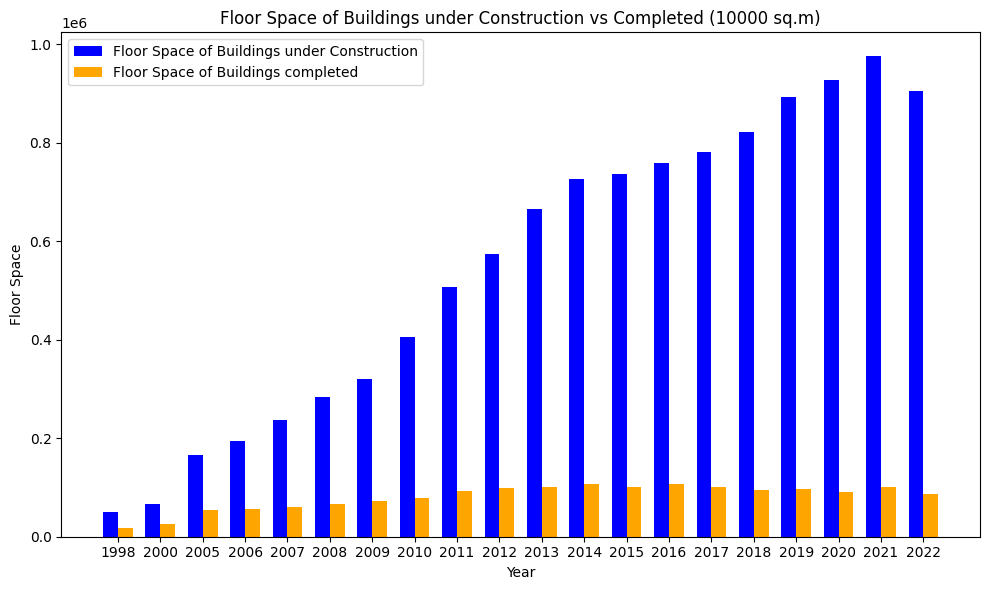

In [69]:
# Set the positions and width for the bars
bar_width = 0.35
bar_positions = np.arange(len(df_08['Year']))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the bars for 'Area of Land Pending for Development'
plt.bar(bar_positions - bar_width/2, df_08['Floor Space of Buildings under Construction'], width=bar_width, color='blue', label='Floor Space of Buildings under Construction')

# Plot the bars for 'Area of Land Purchased in the year'
plt.bar(bar_positions + bar_width/2, df_08['Floor Space of Buildings completed'], width=bar_width, color='orange', label='Floor Space of Buildings completed')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Floor Space')
plt.title('Floor Space of Buildings under Construction vs Completed (10000 sq.m)')
plt.xticks(bar_positions, df_08['Year'])
plt.legend()

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\Construction_Completed.png")

plt.show()

#### Rate of Floor Space of Buildings Completed compared to Under Construction

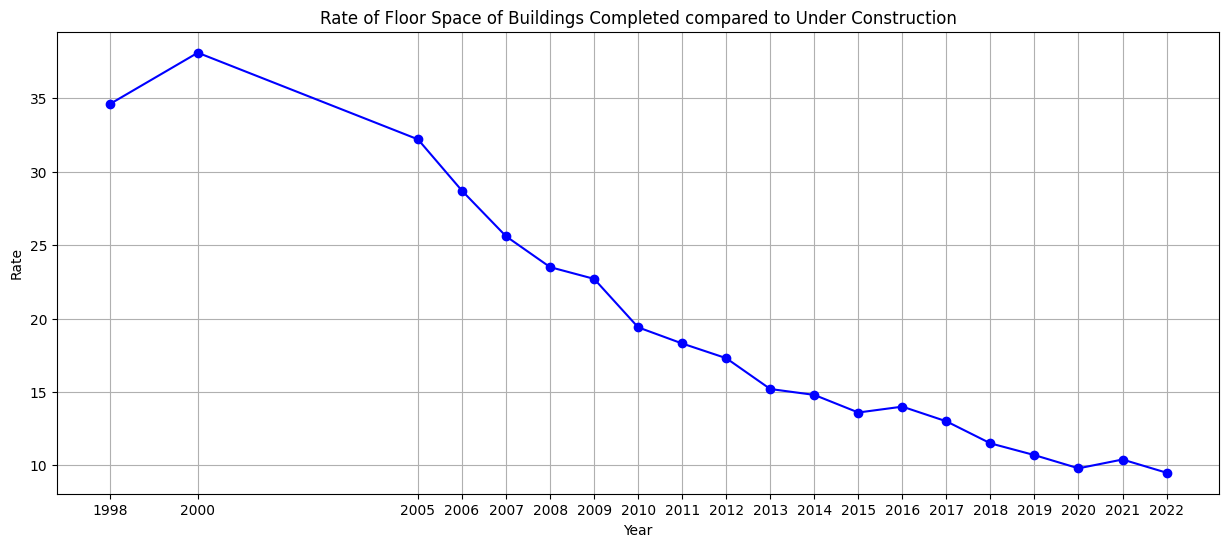

In [70]:
plt.figure(figsize=(15, 6))
plt.plot(df_08['Year'], df_08['Rate of Floor Space of Buildings completed'], marker='o', linestyle='-', color='b')

# Set the ticks on the x-axis to be the specific years in the DataFrame
plt.xticks(df_08['Year'])

plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Rate of Floor Space of Buildings Completed compared to Under Construction')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\construction_completed_rate.png")

plt.show()

### Image E19-12

In [89]:
img_path = "..\..\Data\Raw\Real_estate\E19-12.jpg"
house_price = ocr_scan(img_path)

In [90]:
house_price

'19-12 Average Selling Price of Commercial Buildings by Use (yuan sqm) Average Year Selling Price of Residential Office Buildings for Others Region Commercial Buildings Buildings Business Use Buildings 998 2063 1854 5552 3170 1837 2000 2112 1948 4751 3260 1864 2005 3168 2937 6923 5022 2829 2006 3367 3119 8053 5247 3131 2007 3864 3645 8667 5774 3351 2008 3800 3576 8378 5886 3219 2009 4681 4459 10608 6871 3671 2010 5032 4733 11406 7650 4081 2011 5365 5010 12327 8408 4171 2012 5816 5463 12306 8961 4306 2013 6274 5894 12997 9727 4916 201- 6370 5988 11826 9780 5193 2015 6855 6543 12914 9547 4868 2016 7565 7298 14376 9795 4869 2017 8008 7737 13620 10359 5419 2018 8859 8694 14471 10948 5395 2019 9469 9454 14431 11017 5139 2020 10030 10159 15264 10712 4849 2021 10323 10590 14060 10792 4649 2022 9991 10375 14003 9934 4081 Beijing 38240 47784 26366 14713 8796 Tianjin 15572 15874 11979 13558 8010 Hebei 8021 8081 10156 8714 3428 Shanxi 6713 6591 10675 10593 5012 Inner Mongolia 6288 6274 7137 7407 

In [91]:
paragraph_12 = house_price

# Sentence to be removed
sentence_to_remove = "19-12 Average Selling Price of Commercial Buildings by Use (yuan sqm) Average Year Selling Price of Residential Office Buildings for Others Region Commercial Buildings Buildings Business Use Buildings"

# Remove the specified sentence from the paragraph
updated_paragraph_12 = remove_sentence(paragraph_12, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_12)

998 2063 1854 5552 3170 1837 2000 2112 1948 4751 3260 1864 2005 3168 2937 6923 5022 2829 2006 3367 3119 8053 5247 3131 2007 3864 3645 8667 5774 3351 2008 3800 3576 8378 5886 3219 2009 4681 4459 10608 6871 3671 2010 5032 4733 11406 7650 4081 2011 5365 5010 12327 8408 4171 2012 5816 5463 12306 8961 4306 2013 6274 5894 12997 9727 4916 201- 6370 5988 11826 9780 5193 2015 6855 6543 12914 9547 4868 2016 7565 7298 14376 9795 4869 2017 8008 7737 13620 10359 5419 2018 8859 8694 14471 10948 5395 2019 9469 9454 14431 11017 5139 2020 10030 10159 15264 10712 4849 2021 10323 10590 14060 10792 4649 2022 9991 10375 14003 9934 4081 Beijing 38240 47784 26366 14713 8796 Tianjin 15572 15874 11979 13558 8010 Hebei 8021 8081 10156 8714 3428 Shanxi 6713 6591 10675 10593 5012 Inner Mongolia 6288 6274 7137 7407 4430 Liaoning 8315 8369 8712 8910 3680 Jilin 6955 6970 10603 9043 3202 Heilongjiang 6152 6035 8556 7818 5298 Shanghai 40302 44430 40033 26028 6588 Jiangsu 12226 12963 10961 11545 4570 Zhejiang 18576 202

In [92]:
paragraph = updated_paragraph_12

dict_12 = {
    'id1': 0,
    'id2': 1,
}

result = process_numbers(paragraph, 6, 2, dict_12)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_12.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_12.txt")

Result has been saved to E19_12.txt


In [71]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_12.txt'

years = []
price_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 2:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                price = int(parts[1])
                years.append(year)
                price_list.append(price)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'Average Selling price of Commercial Buildings': price_list}
df_12 = pd.DataFrame(data)

df_12

,Year,Average Selling price of Commercial Buildings
0,1998,2063
1,2000,2112
2,2005,3168
3,2006,3367
4,2007,3864
5,2008,3800
6,2009,4681
7,2010,5032
8,2011,5365
9,2012,5816


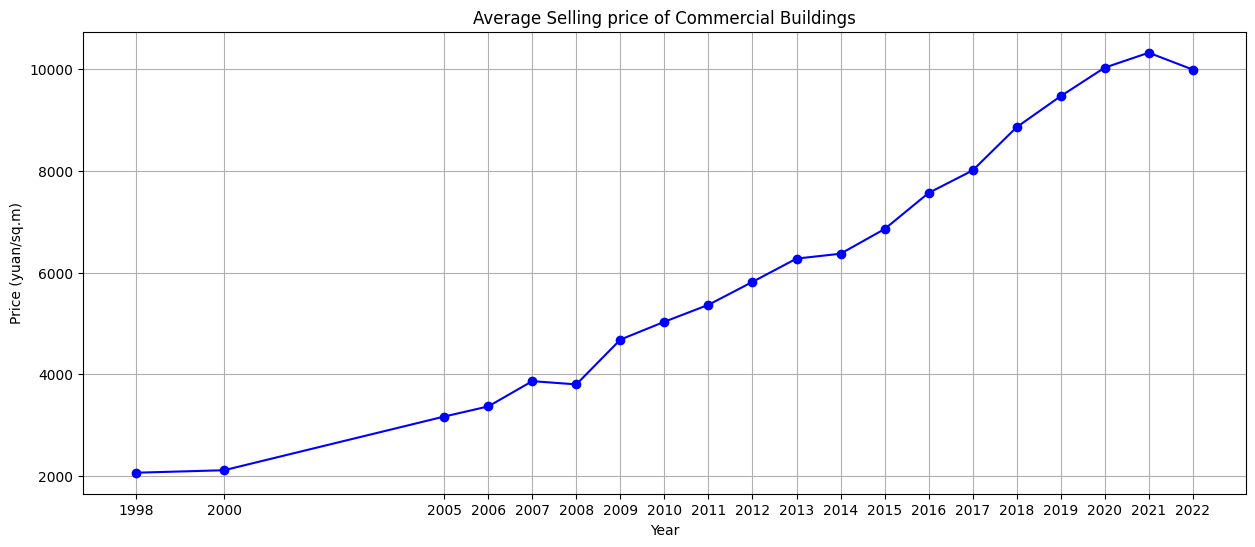

In [72]:
plt.figure(figsize=(15, 6))
plt.plot(df_12['Year'], df_12['Average Selling price of Commercial Buildings'], marker='o', linestyle='-', color='b')

# Set the ticks on the x-axis to be the specific years in the DataFrame
plt.xticks(df_12['Year'])

plt.xlabel('Year')
plt.ylabel('Price (yuan/sq.m)')
plt.title('Average Selling price of Commercial Buildings')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig("..\..\Saved figures\Real estate\House_price.png")

plt.show()

### GDP Growth - Image 3-04

In [ ]:
image_url = 'https://www.stats.gov.cn/sj/ndsj/2023/html/E03-04.jpg'

save_folder = '..\..\Data\Raw\Real_estate'

# Download the image
download_image(image_url, save_folder)

In [29]:
img_path = "..\..\Data\Raw\Real_estate\E03-04.jpg" 
GDP_total = ocr_scan(img_path)

In [30]:
GDP_total

'3-4 Indices of Gross Domestic Product Data in this table are calculated at constant prices_ (preceding year-100) Gross Gross Primary Secondaty Tertiary Agriculture; Industry Construction Wholesale Transport; Hotels Financial Real Estate Others Per Per Year National Domestic Industry Industry Industty Forestry; and Storage and Intermediation Capita Capita Income Product Animal Husbandry Retail Trades and Post Catering GNI GDP and Fishery Services 1978 111.7 111.7 104.1 115.0 113.6 104.1 116.4 99.5 123.1 108 . 118. 110.1 105. 111.2 110.2 110_ 1979 107.6 107_ 106. - 108.2 107 106.1 108 . 102.0 108.7 108.3 111.1 98.0 104- 110.1 106.2 106 1980 107 107.8 98.5 113.5 106. - 98.5 112.6 126.6 98.1 104.3 103.9 107.3 107.9 114.8 106.5 106 1981 105 105. 107.4 101.9 109.6 107 . 101.7 103.2 129.5 101.9 117.5 104.7 96.5 107.4 103.8 103 1982 109.2 109. 111.5 105.6 112.7 111.5 105.8 103.4 99.3 111.4 131.6 143 109. 113.3 107.6 107.4 1983 111.0 110.8 108.3 110.4 114.6 108.3 109.7 117.0 121.2 109. 119. 12

In [34]:
paragraph_3_04 = GDP_total

# Sentence to be removed
sentence_to_remove = "3-4 Indices of Gross Domestic Product Data in this table are calculated at constant prices_ (preceding year-100) Gross Gross Primary Secondaty Tertiary Agriculture; Industry Construction Wholesale Transport; Hotels Financial Real Estate Others Per Per Year National Domestic Industry Industry Industty Forestry; and Storage and Intermediation Capita Capita Income Product Animal Husbandry Retail Trades and Post Catering GNI GDP and Fishery Services"

# Remove the specified sentence from the paragraph
updated_paragraph_gdp = remove_sentence(paragraph_3_04, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_gdp)

1978 111.7 111.7 104.1 115.0 113.6 104.1 116.4 99.5 123.1 108 . 118. 110.1 105. 111.2 110.2 110_ 1979 107.6 107_ 106. - 108.2 107 106.1 108 . 102.0 108.7 108.3 111.1 98.0 104- 110.1 106.2 106 1980 107 107.8 98.5 113.5 106. - 98.5 112.6 126.6 98.1 104.3 103.9 107.3 107.9 114.8 106.5 106 1981 105 105. 107.4 101.9 109.6 107 . 101.7 103.2 129.5 101.9 117.5 104.7 96.5 107.4 103.8 103 1982 109.2 109. 111.5 105.6 112.7 111.5 105.8 103.4 99.3 111.4 131.6 143 109. 113.3 107.6 107.4 1983 111.0 110.8 108.3 110.4 114.6 108.3 109.7 117.0 121.2 109. 119. 126.5 105.2 112.0 109.5 109_ 1984 115.3 115.2 112.9 114.4 119.4 112.9 114.8 110.8 124.7 114.9 108 . 130. 127.7 115.3 113.8 113.7 1985 113.2 113.4 101.8 118.4 118.1 101.8 118.0 122.1 133.5 113. 106.3 117.1 125. 111.5 111.7 111.9 1986 108.6 108.9 103.3 110.2 112.3 103.3 109. 115.8 109. 113. 115.6 130.2 125.9 103.0 107.0 107.3 1987 111.6 111.7 104.7 113.6 114.7 104.7 113.1 117.8 114.7 109. 109. 122.6 129.3 110.3 109.8 109_ 1988 111.3 111.2 102.5 114.3 

In [33]:
paragraph = updated_paragraph_gdp

dict_3_04 = {
    'id1': 0,
    'id2': 2
}

result = process_numbers(paragraph, 17, 3, dict_3_04)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E03_04.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E03_04.txt")

Result has been saved to E03_04.txt


In [73]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E03_04.txt'

years = []
gdp_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 2:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                gdp_growth = float(float(parts[1]) - 100)
                years.append(year)
                gdp_list.append(gdp_growth)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'GDP Growth': gdp_list}
df_gdp = pd.DataFrame(data)

df_gdp

,Year,GDP Growth
0,1998,7.8
1,2000,8.5
2,2005,11.4
3,2006,12.7
4,2007,14.2
5,2008,9.7
6,2009,9.4
7,2010,10.6
8,2011,9.6
9,2012,7.9


### Correlations between Potential factors

In [74]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\price_employ.txt'

years = []
rate_list = []
price_list = []
population_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 4:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                rate = float(parts[1])
                price = int(parts[2])
                population = int(parts[3])
                years.append(year)
                rate_list.append(rate)
                price_list.append(price)
                population_list.append(population)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years,
        'Unemployment Rate': rate_list,
        'Average Selling price of Commercial Buildings': price_list,
        'Population': population_list}

df = pd.DataFrame(data)

df

,Year,Unemployment Rate,Average Selling price of Commercial Buildings,Population
0,1998,3.24,2063,124761
1,2000,3.26,2112,126743
2,2005,4.20,3168,130756
3,2006,4.10,3367,131448
4,2007,4.00,3864,132129
5,2008,4.20,3800,132802
6,2009,4.30,4681,133450
7,2010,4.10,5032,134091
8,2011,4.10,5365,134916
9,2012,4.10,5816,135922


In [10]:
paragraph_19_02_crr = real_estate_enterprises

# Sentence to be removed
sentence_to_remove = "19-2 Number of Enterprises for Real Estate Development (unit) Number of Domestic Enterprises Foreign Year Enterprises Invested State-owned Collective- with Investnent Invested Region Enterprises Enterprises owned from Hong Kong; Enterprises Enterprises Macao and Taiwan"

# Remove the specified sentence from the paragraph
updated_paragraph_02_crr = remove_sentence(paragraph_19_02_crr, sentence_to_remove)

# Display the updated paragraph
print(updated_paragraph_02_crr)

998 24378 19960 7958 4538 3214 1204 2000 27303 23277 6641 3492 2899 1127 2005 56290 50957 4145 1796 3443 1890 2006 58710 53268 3797 1586 3519 1923 2007 62518 56965 3617 1430 3524 2029 2008 87562 81282 3941 1520 3916 2364 2009 80407 74674 3835 1361 3633 2100 2010 85218 79489 3685 1220 3677 2052 2011 88419 83011 3427 1023 3565 1843 2012 89859 84695 3354 904 3451 1713 2013 91444 86379 1739 570 3391 1674 201- 94197 89218 1476 457 3414 1565 2015 93426 88773 1329 409 3235 1418 2016 94948 90408 1093 364 3232 1308 2017 95897 91608 943 319 3066 1223 2018 97937 94063 767 280 2719 1155 2019 99544 95691 671 230 2664 1189 2020 103262 99150 1133 227 2759 1353 2021 105434 101374 1209 208 2703 1357 2022 102852 99054 1387 185 2550 1248 Beijing 1182 1109 Tianjin 1127 1064 Hebei 4036 4002 Shanxi 2768 2756 Inner Mongolia 1711 1710 Liaoning 2757 2558 149 Jilin 1444 1432 Heilongjiang 1359 1344 Shanghai 2660 2297 128 267 Jiangsu 7146 5574 188 426 146 Zhejiang 6599 5341 130 128 Anhui 3962 902 Fujian 3426 3162

In [16]:
paragraph = updated_paragraph_02_crr

dict_02_crr = {
    'id1': 0,
    'id2': 6
}

result = process_numbers(paragraph, 7, 7, dict_02_crr)

with open("..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_02_crr.txt", "w") as file:
    file.write(result)

# print("Result has been saved to E19_02_crr.txt")

Result has been saved to E19_02_crr.txt


In [76]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_02_crr.txt'

years = []
num_fr_enterprises_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 2:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                num_enterprises = int(parts[1])
                years.append(year)
                num_fr_enterprises_list.append(num_enterprises)
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Create the DataFrame
data = {'Year': years, 'Number of Foreign Invested Enterprises': num_fr_enterprises_list}
df_e19_02_crr = pd.DataFrame(data)

df_e19_02_crr

,Year,Number of Foreign Invested Enterprises
0,1998,1204
1,2000,1127
2,2005,1890
3,2006,1923
4,2007,2029
5,2008,2364
6,2009,2100
7,2010,2052
8,2011,1843
9,2012,1713


In [77]:
df['Number of Foreign Invested Enterprises'] = df_e19_02_crr['Number of Foreign Invested Enterprises']

In [78]:
df

,Year,Unemployment Rate,Average Selling price of Commercial Buildings,Population,Number of Foreign Invested Enterprises
0,1998,3.24,2063,124761,1204
1,2000,3.26,2112,126743,1127
2,2005,4.20,3168,130756,1890
3,2006,4.10,3367,131448,1923
4,2007,4.00,3864,132129,2029
5,2008,4.20,3800,132802,2364
6,2009,4.30,4681,133450,2100
7,2010,4.10,5032,134091,2052
8,2011,4.10,5365,134916,1843
9,2012,4.10,5816,135922,1713


In [79]:
file_path = '..\..\Data\Preprocessed\preprocessed_txt\Real_estate\E19_08.txt'

years = []
construction_list = []
completed_list = []
rate_list = []

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        # Clean and split the line into parts using regex to handle different separators
        parts = re.split(r'\s+|[-]', line.strip())
        if len(parts) == 4:
            try:
                # Convert the parts to integers and append to the lists
                year = int(parts[0])
                construction = float(parts[1])
                completed = float(parts[2])
                rate = float(parts[3])
                
                years.append(year)
                construction_list.append(construction)
                completed_list.append(completed)
                rate_list.append(rate)
            
            except ValueError:
                # Handle the case where conversion fails
                print(f"Skipping line due to conversion error: {line.strip()}")

data = {'Year': years,
        'Floor Space of Buildings under Construction': construction_list,
        'Floor Space of Buildings completed': completed_list,
        'Rate of Floor Space of Buildings completed': rate_list}

df_e19_08 = pd.DataFrame(data)

df_e19_08

,Year,Floor Space of Buildings under Construction,Floor Space of Buildings completed,Rate of Floor Space of Buildings completed
0,1998,50770.14,17566.60,34.6
1,2000,65896.92,25104.86,38.1
2,2005,166053.26,53417.04,32.2
3,2006,194786.42,55830.92,28.7
4,2007,236318.24,60606.68,25.6
5,2008,283266.20,66544.80,23.5
6,2009,320368.20,72677.40,22.7
7,2010,405356.40,78743.90,19.4
8,2011,506775.48,92619.94,18.3
9,2012,573417.52,99424.96,17.3


In [80]:
df['Floor Space of Buildings under Construction'] = df_e19_08['Floor Space of Buildings under Construction']

In [81]:
df

,Year,Unemployment Rate,Average Selling price of Commercial Buildings,Population,Number of Foreign Invested Enterprises,Floor Space of Buildings under Construction
0,1998,3.24,2063,124761,1204,50770.14
1,2000,3.26,2112,126743,1127,65896.92
2,2005,4.20,3168,130756,1890,166053.26
3,2006,4.10,3367,131448,1923,194786.42
4,2007,4.00,3864,132129,2029,236318.24
5,2008,4.20,3800,132802,2364,283266.20
6,2009,4.30,4681,133450,2100,320368.20
7,2010,4.10,5032,134091,2052,405356.40
8,2011,4.10,5365,134916,1843,506775.48
9,2012,4.10,5816,135922,1713,573417.52


In [82]:
df['GDP Growth'] = df_gdp['GDP Growth']

In [83]:
df

,Year,Unemployment Rate,Average Selling price of Commercial Buildings,Population,Number of Foreign Invested Enterprises,Floor Space of Buildings under Construction,GDP Growth
0,1998,3.24,2063,124761,1204,50770.14,7.8
1,2000,3.26,2112,126743,1127,65896.92,8.5
2,2005,4.20,3168,130756,1890,166053.26,11.4
3,2006,4.10,3367,131448,1923,194786.42,12.7
4,2007,4.00,3864,132129,2029,236318.24,14.2
5,2008,4.20,3800,132802,2364,283266.20,9.7
6,2009,4.30,4681,133450,2100,320368.20,9.4
7,2010,4.10,5032,134091,2052,405356.40,10.6
8,2011,4.10,5365,134916,1843,506775.48,9.6
9,2012,4.10,5816,135922,1713,573417.52,7.9


In [84]:
df_crr = pd.DataFrame()

In [85]:
df_crr['Year'] = df['Year']
df_crr['Average Selling price of Commercial Buildings'] = df['Average Selling price of Commercial Buildings']
df_crr['Unemployment Rate'] = df['Unemployment Rate']
df_crr['Population'] = df['Population']
df_crr['Average Number of employed people in Foreign Invested Enterprises'] = df_03_f['Average Number of employed people in Foreign invested Enterprises']
df_crr['Floor Space of Buildings under Construction'] = df['Floor Space of Buildings under Construction']
df_crr['GDP Growth'] = df['GDP Growth']

In [86]:
df_crr

,Year,Average Selling price of Commercial Buildings,Unemployment Rate,Population,Average Number of employed people in Foreign Invested Enterprises,Floor Space of Buildings under Construction,GDP Growth
0,1998,2063,3.24,124761,33366,50770.14,7.8
1,2000,2112,3.26,126743,30631,65896.92,8.5
2,2005,3168,4.20,130756,58733,166053.26,11.4
3,2006,3367,4.10,131448,61084,194786.42,12.7
4,2007,3864,4.00,132129,77932,236318.24,14.2
5,2008,3800,4.20,132802,85087,283266.20,9.7
6,2009,4681,4.30,133450,75463,320368.20,9.4
7,2010,5032,4.10,134091,76332,405356.40,10.6
8,2011,5365,4.10,134916,68500,506775.48,9.6
9,2012,5816,4.10,135922,70108,573417.52,7.9


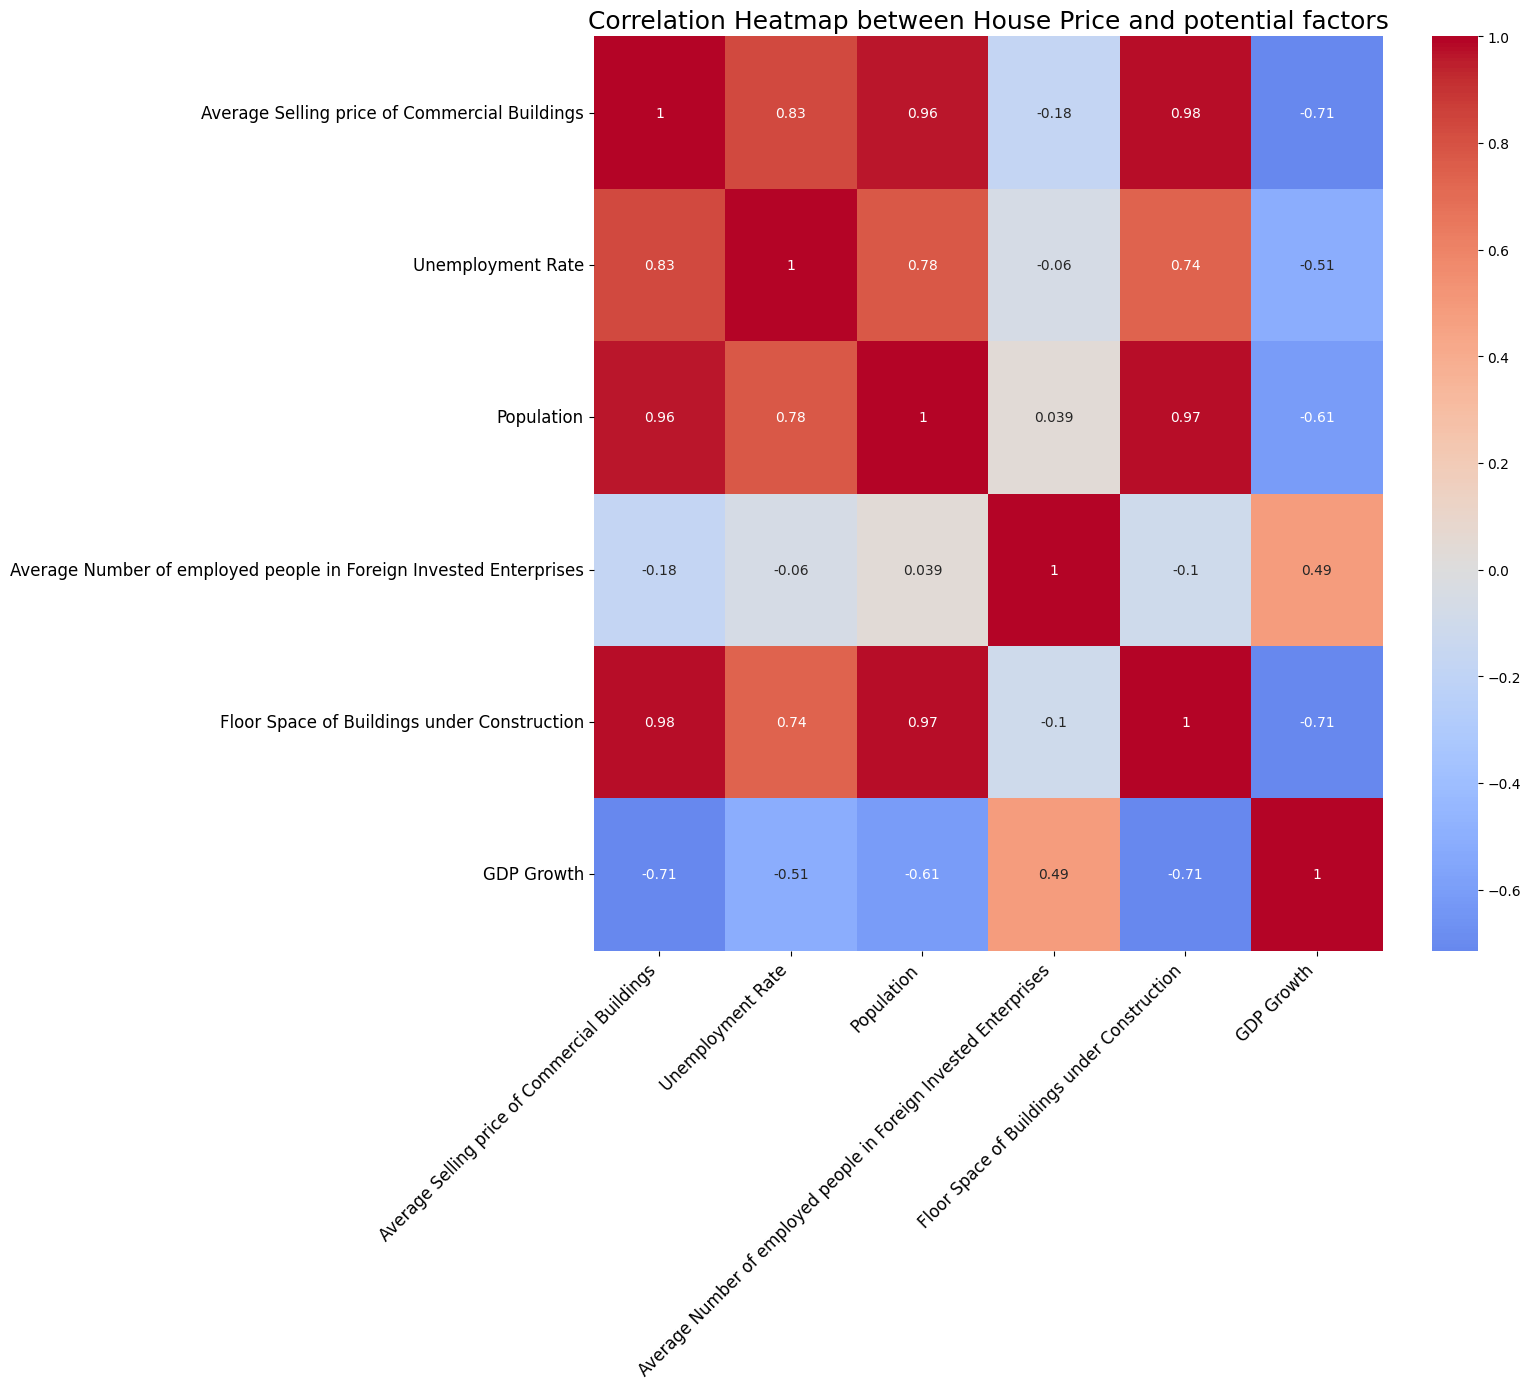

In [87]:
df_for_corr = df_crr.drop(columns=['Year'])

# Calculate the correlation matrix
correlation_matrix = df_for_corr.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(16, 14)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 10})  # Adjust the annotation size
plt.title('Correlation Heatmap between House Price and potential factors', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=12)  # Rotate y-axis labels
plt.tight_layout()  # Adjust layout to fit everything

# Save the figure to a PNG file
plt.savefig('..\..\Saved figures\Real estate\Correlation.png', dpi=300)
plt.show()

### Word Cloud

In [93]:
def get_article_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Assuming articles are within <p> tags of HTML
    paragraphs = soup.find_all('p')
    article_text = ' '.join([p.get_text() for p in paragraphs])
    
    return article_text

urls = [
    'https://www.scmp.com/business/china-business/article/3248726/chinas-home-prices-continue-decline-biggest-drop-nearly-9-years-easing-measures-fail-buoy-buyer',
    'https://www.scmp.com/economy/china-economy/article/3237708/property-crisis-pushes-china-increase-financial-risk-monitoring-asset-disposal-troubled-small-banks',
    'https://www.scmp.com/business/china-business/article/3205513/top-100-chinese-developers-saw-sales-plunge-40-cent-2022-property-crisis-deepened',
    'https://www.scmp.com/business/china-business/article/3200303/shanghais-housing-market-slump-worsen-wealthy-owners-cash-out-and-leave-mainland-china-fears',
    'https://fortune.com/2022/08/15/real-estate-market-house-prices-decline-china-bust/',
    'https://www.scmp.com/business/article/3238996/chinas-property-crisis-stimulus-measures-unlikely-prop-beleaguered-home-sales-long-run-moodys-warns',
    'https://www.scmp.com/business/china-business/article/3241729/no-end-sight-chinas-property-crisis-new-home-prices-post-sharpest-decline-february-2015',
    'https://www.scmp.com/economy/china-economy/article/3232716/chinas-too-big-fail-property-giants-just-tip-real-estate-crisis-suppliers-are-being-dragged-death',
    'https://www.scmp.com/economy/china-economy/article/3238242/chinas-debt-ridden-local-governments-face-rising-pressure-repay-debt-and-fallout-possible-property',
    'https://www.scmp.com/economy/china-economy/article/3231900/chinas-property-crisis-plagues-its-economy-and-financial-system-lehman-moment-looming'
    
]

text_data = ''
for url in urls:
    text_data += get_article_text(url)

In [73]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

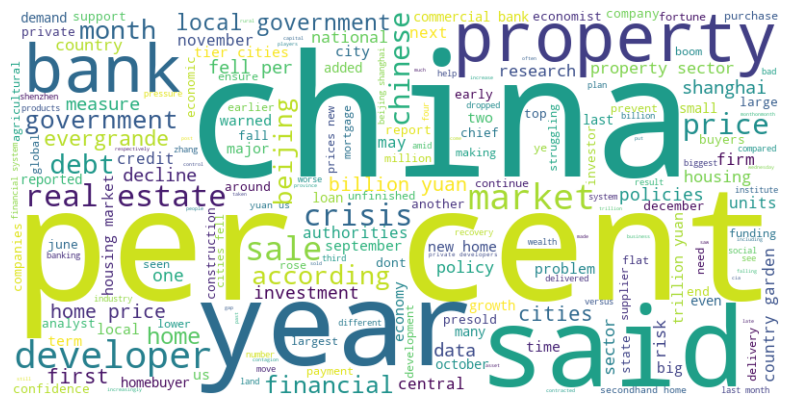

In [94]:
text_data = re.sub(r'[^a-zA-Z\s]', '', text_data)
text_data = text_data.lower()

# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in text_data.split() if word not in stop_words]

# Join the words back into a single string
filtered_text = ' '.join(filtered_words)

# Create and configure the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(filtered_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("..\..\Saved figures\Real estate\WordCloud.png")
plt.show()